In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import pickle
import scipy.sparse as sp
import datetime
from sklearn import metrics

# Import Base LSCC

In [3]:
#################
# Load datasets #
#################

root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results'
root_base = root_results+'/Base Network/'

# Load LSCC
root_lscc = root_base+'/base_network_lscc.npz'
with open(root_lscc, 'rb') as handle:
        lscc_dict = pickle.load(handle)
        
##############################
# Generate DiGraph from data #
##############################

lscc = nx.from_dict_of_dicts(lscc_dict,create_using = nx.DiGraph)
lscc_nodes = list(lscc.nodes())
n_nodes = len(lscc_nodes)

# Store node numbers
node_numbers = {i : lscc_nodes[i] for i in range(n_nodes)}

# Load geom_dict
root_geom_dict = root_base+'/base_geom_dict.pickle'
with open(root_geom_dict, 'rb') as handle:
        geom_dict = pickle.load(handle)
# Geom dict for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

# Compute adjacency matrix and node list of LSCC
A = nx.adjacency_matrix(lscc).toarray()
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)

# Subtract self-loops
B = A- np.diag(np.diag(A))

In [13]:
root_figure = '/Users/ignaciosacristanbarba/Documents/M4R/Figures/'

# Descriptive Statistics

## Basic characteristics

In [14]:
from sklearn.linear_model import LinearRegression

def R2_score(X,y):
    
    '''
    Perform univariate linear regression and return R2 score
    '''
    
    X = X.reshape(-1, 1)

    # Linear Regression 
    LsLin = LinearRegression().fit(X, y)

    # Coefficient of determination 
    return LsLin.score(X,y)

In [15]:
# Compute basic characteristics of LSCC
n_nodes = len(lscc.nodes())
weight_dict = nx.get_edge_attributes(lscc,'weight')
weights = np.asarray(list(weight_dict.values()))
n_edges = len(weights)
print('Number of nodes:', n_nodes)
print('Number of edges:', n_edges)
print('n_total:', np.around(np.sum(A),2))
print('n_inter:', np.around(np.sum(B),2))
print('n_intra:', np.around(np.sum(np.diag(A)),2))
print('Minimum link weight', np.around(np.min(weights),2))
print('Maximum link weight', np.around(np.max(weights),2))
print('Mean link weight:', np.around(weights.mean(),2))
print('Coefficient of variation of link weight:', np.around(weights.std()/weights.mean(),2))

# Compute sparsity of adjacency matrix
A_lscc = nx.adjacency_matrix(lscc).toarray()
sparsity_A = 100*np.sum(A_lscc == 0.) / A_lscc.size
print('Sparsity of adjacency matrix A:', np.around(sparsity_A,2),'%')

# Compute statistical symmetry
A = nx.adjacency_matrix(lscc).toarray()
y_true = A.flatten()
y_pred = np.transpose(A).flatten()
print('R2 of statistical symmetry:', R2_score(y_true,y_pred))

Number of nodes: 3125
Number of edges: 37349
n_total: 12892495.34
n_inter: 2475526.97
n_intra: 10416968.37
Minimum link weight 1.43
Maximum link weight 72252.09
Mean link weight: 345.19
Coefficient of variation of link weight: 5.66
Sparsity of adjacency matrix A: 99.62 %
R2 of statistical symmetry: 0.9999786872928359


In [16]:
# Compute statistical symmetry for non-zero elements
print('R2 for statistical symmetry of A:', 
      np.around(R2_score(B[B>0], B.transpose()[B>0]),5))

mae = np.around(metrics.mean_absolute_error(B[B>0], B.transpose()[B>0]),5)
print('MAE for statistical symmetry of B:',mae)
print('RMSE for statistical symmetry of B:',
      np.around(np.sqrt(metrics.mean_squared_error(B[B>0], B.transpose()[B>0])),5))

R2 for statistical symmetry of A: 0.99781
MAE for statistical symmetry of B: 4.82965
RMSE for statistical symmetry of B: 9.43931


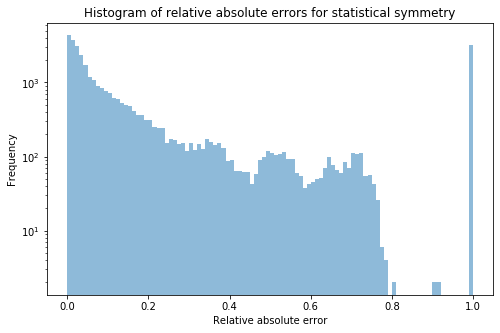

In [17]:
# Compute absolute errors
mean = (B[B>0] + (B.transpose())[B>0])
diff = abs(B[B>0]- (B.transpose())[B>0])

# Plot histogram for relative absolute errors
fig, ax = plt.subplots(1,figsize =(8,5))
ax.hist(diff/mean,100,alpha=0.5)
ax.set(yscale='log', xlabel = 'Relative absolute error',ylabel='Frequency',
      title='Histogram of relative absolute errors for statistical symmetry')
plt.show()
fig.savefig(root_figure+'/Base_lscc'+'/LSCC_DistrSymmetry.svg', dpi=fig.dpi,bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Number of one-ways: 3226
Q2: 1.5714285714285714
Q2: 3.2285714285714286
Q2: 6.178571428571429


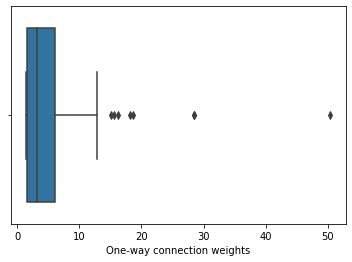

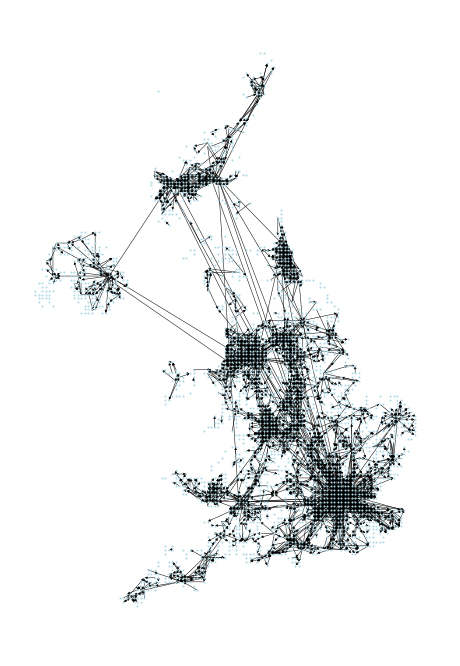

In [21]:
# Get one-way connections
ind1 = np.asarray((2*abs(B - B.transpose())/(B+B.transpose()))==2,dtype='int')
C = ind1*B

print('Number of one-ways:', np.sum(C>0))
print('Q2:',np.percentile(C[C>0],25))
print('Q2:',np.percentile(C[C>0],50))
print('Q2:',np.percentile(C[C>0],75))

# Boxplot of weights
fig, ax = plt.subplots(1)
sns.boxplot(C[C>0], ax=ax)
ax.set(xlabel='One-way connection weights')
plt.show()
fig.savefig(root_figure+'/Base_lscc'+'/asymmetry_weights.pdf', dpi=fig.dpi,bbox_inches='tight')

# Draw graph with one-way connections only
G = nx.from_numpy_array(C,create_using = nx.DiGraph)
fig, ax = plt.subplots(1,figsize =(8,12))
nx.draw(G, ax=ax,pos=geom_dict_numbers,node_size=1, width = 0.5, arrows = True, node_color = 'lightblue',
       arrowsize=5)
plt.show()
fig.savefig(root_figure+'/Base_lscc'+'/asymmetry_edges.eps', dpi=fig.dpi,bbox_inches='tight')

Ratio of positive absolute errors: 91.6 %


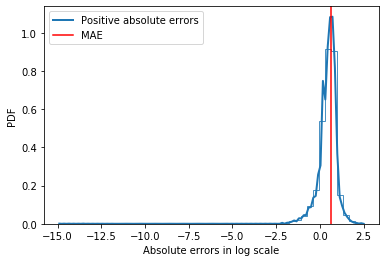

In [22]:
# Compute absolute errors
diff = abs(A[A>0]- (A.transpose())[A>0])
print('Ratio of positive absolute errors:',
      np.around(100*len(diff[diff>0])/len(diff),1), '%')
ax = sns.distplot(np.log10(diff[diff>0]),
                  kde_kws={ "lw": 2, 'label' : 'Positive absolute errors'},
                  hist_kws={"histtype": "step", "linewidth": 1,
                            "alpha": 0.8})
ax.axvline(x = np.log10(metrics.mean_absolute_error(A[A>0], A.transpose()[A>0])), 
           color = 'red', label = 'MAE')
ax.set(xlabel = 'Absolute errors in log scale', ylabel = 'PDF')
ax.legend()
plt.show()

## Weight distribution

In [23]:
B = A-np.diag(np.diag(A))

# Compute in- and out-strengths
d_out = np.sum(B,axis=1)
d_in = np.sum(B,axis=0)

# Compute self-loop strengths
self_loops = np.diag(A)
print('Number of nodes without self-loops: ', sum(self_loops == 0))


# Correlation of in- and out-strengths
print('R2 for correlation of in-strengths with out-strengths:',
      np.around(R2_score(d_in,d_out),5))
print('MAE for in-strengths vs. out-strengths:',
      np.around(metrics.mean_absolute_error(d_in,d_out),1))
print('RMSE for in-strengths vs. out-strengths:',
      np.around(np.sqrt(metrics.mean_squared_error(d_in,d_out)),1))

# Correlation between in- and out-strengths and self-loops
print('R2 for correlation of self-loops with in-strengths:',
      np.around(R2_score(self_loops,d_in),5))
print('R2 for correlation of self-loops Centrality with out-strengths:',
      np.around(R2_score(self_loops,d_out),5))

Number of nodes without self-loops:  0
R2 for correlation of in-strengths with out-strengths: 0.9984
MAE for in-strengths vs. out-strengths: 30.5
RMSE for in-strengths vs. out-strengths: 117.6
R2 for correlation of self-loops with in-strengths: 0.78417
R2 for correlation of self-loops Centrality with out-strengths: 0.76517


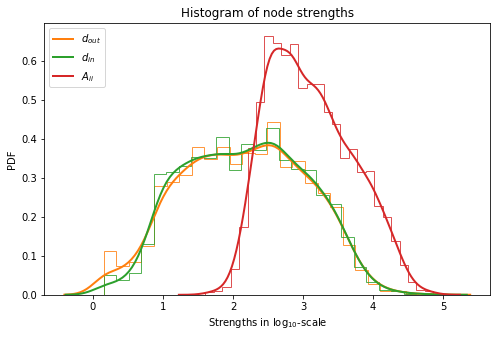

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [27]:
fig, ax = plt.subplots(1,figsize =(8,5))

sns.distplot(np.log10(d_out), ax = ax, color = 'C1',
                  kde_kws={ "lw": 2, 'label' : r'$d_{out}$'},
                  hist_kws={"histtype": "step", "linewidth": 1,
                            "alpha": 0.8})
sns.distplot(np.log10(d_in), ax = ax, color = 'C2',
                  kde_kws={ "lw": 2, 'label' : r'$d_{in}$'},
                  hist_kws={"histtype": "step", "linewidth": 1,
                            "alpha": 0.8})
sns.distplot(np.log10(self_loops), ax = ax, color = 'C3',
                  kde_kws={ "lw": 2, 'label' : r'$A_{ii}$'},
                  hist_kws={"histtype": "step", "linewidth": 1,
                            "alpha": 0.8})
ax.set(xlabel = r'Strengths in $\log_{10}$-scale', ylabel = 'PDF',
      title='Histogram of node strengths')
ax.legend()
plt.show()

fig.savefig(root_figure+'/Base_lscc'+'/LSCC_DistrSrength.eps', dpi=fig.dpi,bbox_inches='tight')

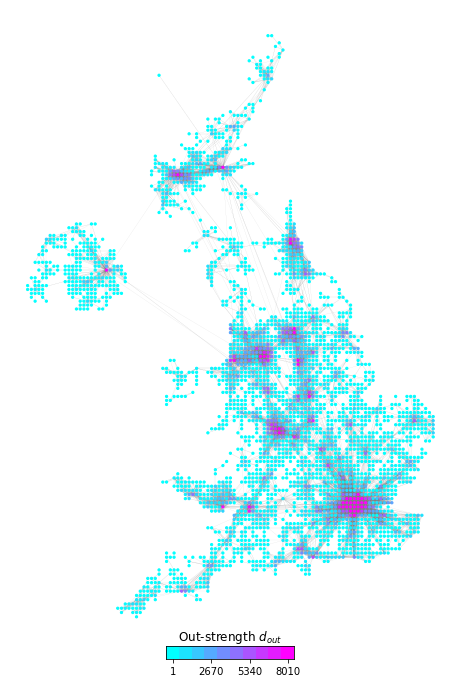

In [25]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [40, 0.8]})
# Adjust fig size and spaces between subplots
fig.subplots_adjust(hspace=0)
fig.set_size_inches(8,12)

nx.draw(lscc, ax=ax1,pos=geom_dict,node_size=5, width = 0.05, arrows = False, edge_color = 'grey',
       node_color=d_out,cmap = 'cool',vmax = np.percentile(d_out,99))

ax2.imshow(np.linspace(np.percentile(d_out,1),np.percentile(d_out,99),10).reshape(1,10),
           cmap='cool')
ax2.set(yticks=[],xticks = np.arange(0,10,3),
        xticklabels=np.asarray(np.linspace(np.min(d_out),np.percentile(d_out,99),10),dtype='int')[np.arange(0,10,3)],
        title=r'Out-strength $d_{out}$')

plt.show()
fig.savefig(root_figure+'/Base_lscc'+'/LSCC_OutStrength.eps', dpi=fig.dpi,bbox_inches='tight')

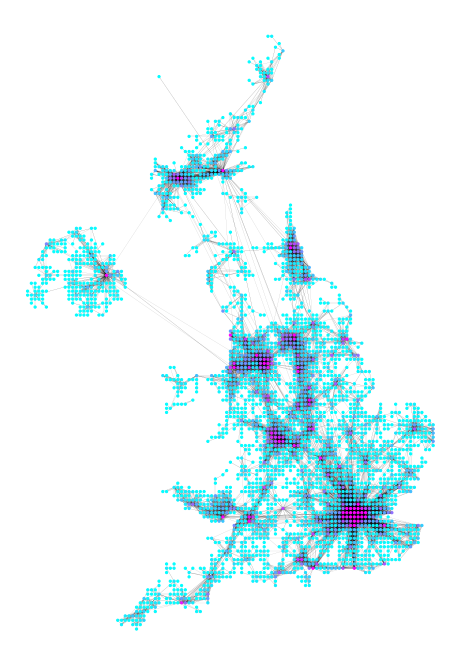

In [32]:
# Create subplot and draw graph
fig, ax = plt.subplots(1,figsize =(8,12))
nx.draw(lscc, ax=ax,pos=geom_dict,node_size=5, width = 0.05, arrows = False, 
       node_color=self_loops,cmap = 'cool',vmax = np.percentile(self_loops,99))
plt.show()
fig.savefig(root_figure+'/Base_lscc'+'/LSCC_SelfLoops.eps', dpi=fig.dpi,bbox_inches='tight')

## Node centralities

### Betweenness Centrality

In [29]:
# Compute reciprocal weights for LSCC
weights = nx.get_edge_attributes(lscc,'weight')
reciprocal = {}

for key,value in weights.items():
    reciprocal[key] = 1/value

nx.set_edge_attributes(lscc, reciprocal, 'reciprocal')

In [30]:
bc = np.asarray(list(dict(nx.betweenness_centrality(lscc,weight='reciprocal')).values())) 

In [31]:
# Correlation between PageRank and strengths
print('R2 for correlation of Betweenness Centrality with in-strengths:',
      np.around(R2_score(bc,d_in),5))
print('R2 for correlation of Betweenness Centrality with out-strengths:',
      np.around(R2_score(bc,d_out),5))

R2 for correlation of Betweenness Centrality with in-strengths: 0.42565
R2 for correlation of Betweenness Centrality with out-strengths: 0.44692


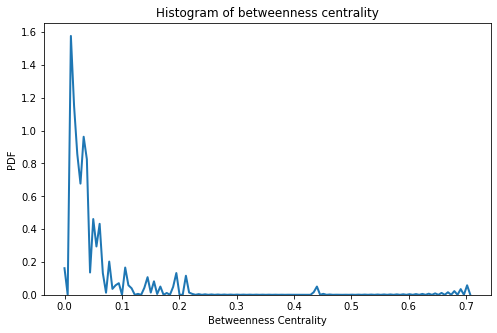

In [33]:
fig, ax = plt.subplots(1,figsize =(8,5))
sns.distplot(bc, ax=ax, kde_kws={ "lw": 2},hist=False)
ax.set(xlabel = 'Betweenness Centrality', ylabel = 'PDF',
      title='Histogram of betweenness centrality')
plt.show()
fig = ax.get_figure()
fig.savefig(root_figure+'/Base_lscc'+'/LSCC_DistrBC.eps', dpi=fig.dpi,bbox_inches='tight')

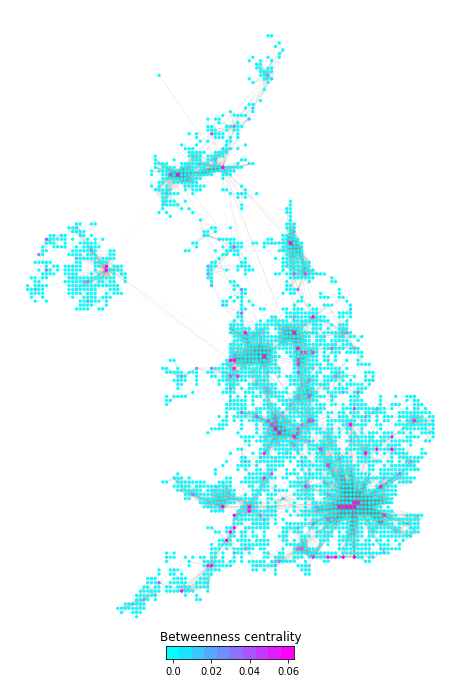

In [37]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [40, 0.8]})
# Adjust fig size and spaces between subplots
fig.subplots_adjust(hspace=0)
fig.set_size_inches(8,12)

nx.draw(lscc, ax=ax1,pos=geom_dict,node_size=5, width = 0.05, arrows = False, edge_color = 'grey',
       node_color=bc,cmap = 'cool',vmax = np.percentile(bc,99))


ax2.imshow(np.linspace(np.percentile(bc,1),np.percentile(bc,99),10).reshape(1,10),
           cmap='cool')
ax2.set(yticks=[],xticks = np.arange(0,10,3),
        xticklabels=np.around(np.linspace(np.min(bc),np.percentile(bc,99),10),2)[np.arange(0,10,3)],
        title=r'Betweenness centrality')

plt.show()
fig.savefig(root_figure+'/Base_lscc'+'/LSCC_BetweennessCentrality.eps', dpi=fig.dpi,bbox_inches='tight')

### PageRank

In [34]:
pr = np.asarray(list(dict(nx.pagerank(lscc)).values())) 

# Correlation between PageRank and strengths
print('R2 for correlation of PageRank with in-strengths:',
      np.around(R2_score(pr,d_in),5))
print('R2 for correlation of PageRank with out-strengths:',
      np.around(R2_score(pr,d_out),5))

R2 for correlation of PageRank with in-strengths: 0.239
R2 for correlation of PageRank with out-strengths: 0.23889


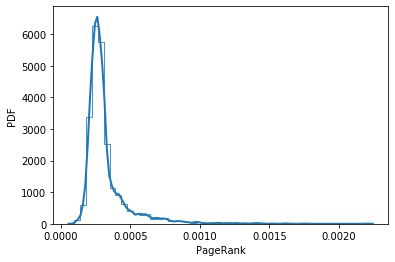

In [35]:
ax = sns.distplot(pr, kde_kws={ "lw": 2},
                  hist_kws={"histtype": "step", "linewidth": 1,
                            "alpha": 0.8})
ax.set(xlabel = 'PageRank', ylabel = 'PDF')
plt.show()

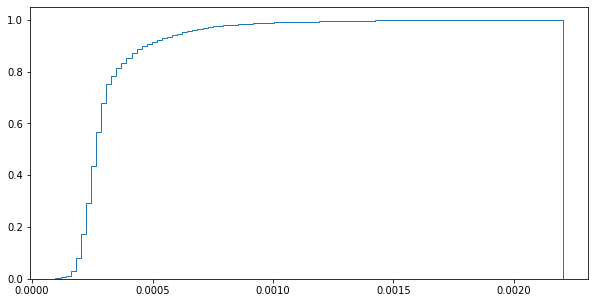

In [36]:
# Plot histogram for degree distribution in log scale
fig, ax = plt.subplots(1,figsize =(10,5))
ax.hist(pr,100,density=True, cumulative = True, histtype = 'step')
plt.show()